In [25]:
#Student ID: 22104958

# **CMT309 - Computational Data Science - Data Science Portfolio**

# Part 2 - Statistical Analysis (55 marks)

This question has been created to test your statistical analysis and programming knowledge in Python. 

You are given a `csv` file, which include various data entries for UFC fights played between 1994 up to 2021. Each row presents several statistics for a fighter in a specific fight (`Match_ID`) where the result of the fight is stored in (`Winner`). Descriptions for some other important column names is automatically downloaded in a txt file. 

In this exercise, you are asked to perform a number of operations to:
 - perform statistical analysis of the data, and
 - gain insights from the data.

## P2.0) Suggested/Required Imports

In [26]:
# suggested imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy
from urllib import request
import scipy.stats as stats
from statsmodels import graphics
import arviz as az
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, RocCurveDisplay, auc, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style(style="darkgrid", rc={"axes.facecolor": ".9", "grid.color": ".8"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")
!pip install kaleido
import plotly.express as px
import kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
module_url = f"https://drive.google.com/uc?export=view&id=1eZuwv6os65YqO6xwyj6i9ojq3c6yAeCE"
module_url2 = f"https://drive.google.com/uc?export=view&id=1gejV-dCzznzCNCrP6xgBtflWK3sny_ar"
module_name = 'UFC_data.csv'
name2 = 'descriptions.txt'
with request.urlopen(module_url) as f, open(module_name,'w') as outf, request.urlopen(module_url2) as f2, open(name2,'w') as outf2:
  a = f.read()
  outf.write(a.decode('utf-8'))
  a2 = f2.read()
  outf2.write(a2.decode('utf-8'))
df = pd.read_csv('UFC_data.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df.rename(columns={'Win_by_KO/TKO':'Win_by_KO_TKO', 'Avg_CTRL_time(seconds)':'Avg_CTRL_time',
                        'Avg_opp_CTRL_time(seconds)':'Avg_opp_CTRL_time', 'Total_time_fought(seconds)':'Total_time_fought'})
df.head()

,Fighter,Referee,Date,Location,Winner,Title_bout,Weight_class,Avg_KD,Avg_opp_KD,Avg_SIG_STR_pct,...,Win_by_Decision_Split,Win_by_Decision_Unanimous,Win_by_KO_TKO,Win_by_Submission,Win_by_TKO_Doctor_Stoppage,Height_cms,Reach_cms,Weight_lbs,Age,Match_ID
0,Gustavo Lopez,1,20/03/2021,1,0,1,1,0.000000,0.0,0.420000,...,0,0,0,1,0,165.10,170.18,135,31,4347
1,Roman Dolidze,2,20/03/2021,1,0,1,2,0.500000,0.0,0.660000,...,1,0,1,0,0,187.96,193.04,205,32,2867
2,Marcus LeVesseur,3,05/10/2012,2,1,1,3,0.000000,0.0,0.500000,...,0,0,0,0,0,175.26,177.80,155,30,3106
3,Hacran Dias,4,18/05/2013,3,0,1,4,0.000000,0.0,0.430000,...,0,1,0,0,0,172.72,175.26,155,28,3765
4,Daron Cruickshank,5,25/07/2015,4,0,1,3,0.125977,0.0,0.382295,...,1,2,3,0,0,172.72,182.88,155,30,672


## P2.1. – `pandas` for Probability and Visualisation (15 marks) 

### P2.1.1. The Tall, Young and Winner(3 marks)
Find the probability of a fighter winning the fight while *(1) being younger than 25 years of age*, and *(2) taller than 180 cms*. Write a one-liner to solve this. $P\big[\text{Win} | (\text{height_cms} > 180)\cap \text{Age} <25\big]$

In [28]:
probability0 = len(df[(df['Winner'] == 1) & (df['Age'] < 25) & (df['Height_cms'] > 180)]) / (len(df))

print(probability0)

0.026163741415022347


###P2.1.2. The most durable fighters (3 marks)
Find the most durable fighters among all the fighters in the dataframe. You need to filter out `df` for the **10 most** durable fighters who **wins** where they **received higher than 100 significant strikes 'landed'**, but **not had any knockdowns (KD)**.    

In [29]:
filtered_df = df[(df['Winner'] == 1) & (df['Avg_KD'] == 0) & (df['Avg_opp_SIG_STR_landed'] > 100)]
sorted_df = filtered_df.sort_values(by='Avg_opp_SIG_STR_landed', ascending=False).head(10)
top_10_durable_fighters = sorted_df['Fighter']
print(top_10_durable_fighters)


5197         Leslie Smith
4936           Gabe Green
111         Lara Procopio
6312       Justin Gaethje
9076           Rick Glenn
2500         Irene Aldana
4253    Roxanne Modafferi
71         John Castaneda
4922         Clay Collard
2137      Steven Peterson
Name: Fighter, dtype: object


###P2.1.3. KO-Machines (3 marks)
Find probability of fighters who has **at least 2 KO/TKOs** ,and whose **win by KO/TKO ratio is higher than 0.75**.

In [30]:
filtered_df = df[(df['Win_by_KO_TKO'] >= 2) & (df['Win_by_KO_TKO'] / df['Wins'] > 0.75)]
probability1 = len(filtered_df) / (len(df)) #Probability here is just frequency
print(probability1)


0.051782404883898396


### P2.1.4 - Ideal Body & Strategy (6 marks)
Create a figure with two subplots by using a filtered-out version of the dataframe `df` including only rows of **WINNERS**.  
- Subplot 1: Create a **2D histogram** via hexagonal bins for `'Height_cms'` and `'Weight_lbs'` columns of the data frame. Color corresponds to number of winners for each height-weight pair.
- Subplot 2: Create a heatmap figure for plotting correlations between columns of `['Avg_KD', 'Avg_REV', 'Avg_SIG_STR_landed', 'Avg_TOTAL_STR_landed' 'Avg_TD_landed', 'Avg_HEAD_landed', 'Avg_BODY_landed', 'Avg_LEG_landed' 'Avg_DISTANCE_landed', 'Avg_CLINCH_landed', 'Avg_GROUND_landed', 'Avg_CTRL_time']`

**In order to solve this question, you need to use either `pandas` or `matplotlib` library visualisation commands. You cannot use `seaborn, plotly` or other libraries for this question.**

**You do not have to replicate the figures given below, but axes labels, titles and other visualisation details should be there.**

![](https://drive.google.com/uc?export=view&id=1aGAk4_6KMcOjWmSWhqYlqmkDGJAY8sR8)

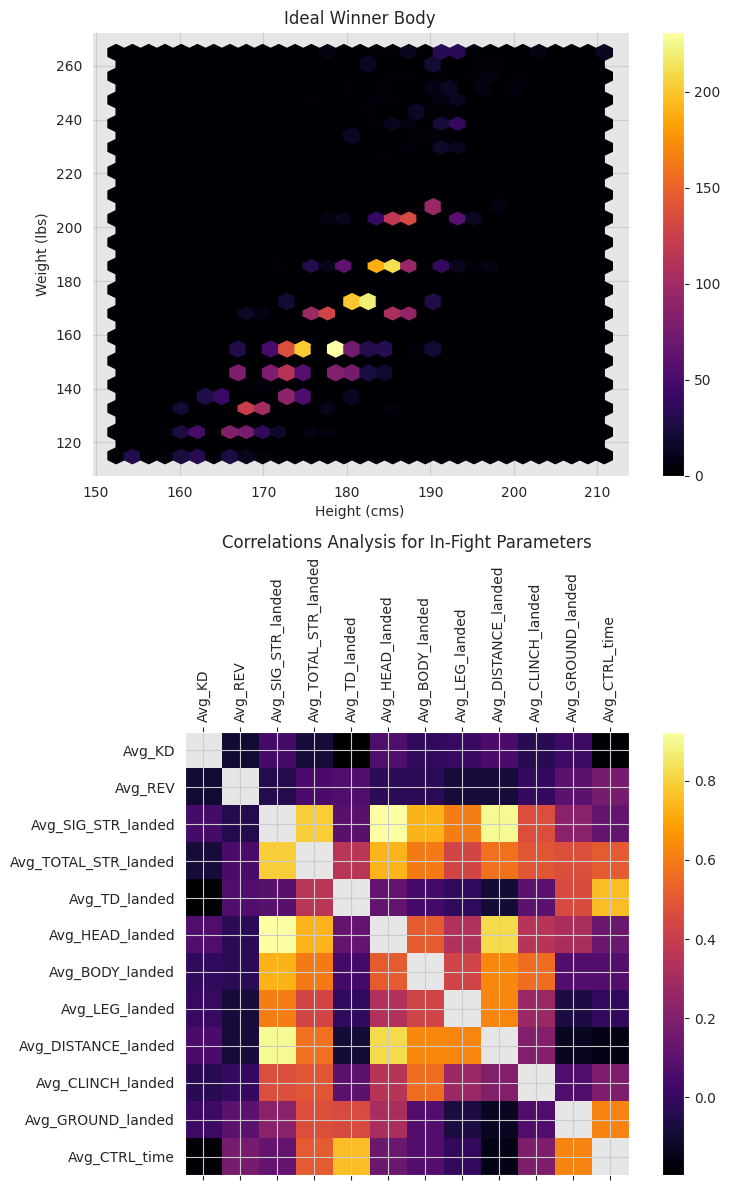

In [31]:
# Filter the dataframe to include only rows of winners
winners_df = df[df['Winner'] == 1]

#Visualisation
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# Subplot 1: 2D histogram with hexagonal bins for Height_cms and Weight_lbs
hb = ax1.hexbin(winners_df['Height_cms'], winners_df['Weight_lbs'], gridsize=30, cmap='inferno')
ax1.set_xlabel('Height (cms)')
ax1.set_ylabel('Weight (lbs)')
fig.colorbar(hb)
ax1.set_title('Ideal Winner Body')


# Subplot 2: Heatmap for correlations between selected columns
selected_columns = ['Avg_KD', 'Avg_REV', 'Avg_SIG_STR_landed', 'Avg_TOTAL_STR_landed',
                    'Avg_TD_landed', 'Avg_HEAD_landed', 'Avg_BODY_landed', 'Avg_LEG_landed',
                    'Avg_DISTANCE_landed', 'Avg_CLINCH_landed', 'Avg_GROUND_landed', 'Avg_CTRL_time']
correlation_matrix = winners_df[selected_columns].corr()

# Set diagonal elements to np.nan to blank them out
np.fill_diagonal(correlation_matrix.values, np.nan)

cax = ax2.matshow(correlation_matrix, cmap='inferno')
fig.colorbar(cax)
ax2.set_title('Correlations Analysis for In-Fight Parameters')

ax2.set_xticks(np.arange(len(selected_columns)))
ax2.set_yticks(np.arange(len(selected_columns)))
ax2.set_xticklabels(selected_columns, rotation=90)   #labels are rotated for better readability 
ax2.set_yticklabels(selected_columns)

plt.tight_layout()
plt.show()


##P2.2. – Variable selection via linear regression analysis (9 marks)

In **variable selection** ('variable' means the same as 'predictor'), variables get iteratively added or removed from the regression model. Once finished, the model typically contains only a subset of the original variables. It makes it easier to interpret the model, and in some cases it makes it generalise better to new data. 

To perform variable selection, create a function `select_variable(df, main_pred, main_target, alpha)`, where 
 
 - `main_pred` is a list of variables includes columns of the data frame except for `'Fighter',	'Referee',	'Date'` and `Match_ID`.
 - `main_target` is the variable for the regression, `'Winner'` 
 - `alpha` is the significance level for selecting significant predictors

The function should return

 - `main_pred` is a list which stores the selected subset of initial `main_pred`.

To calculate regression fits and $p$-values you will use `statsmodels`. The general procedure follows two stages:

 - **Stage 1 (adding predictors):** you build a model by adding variables one after the other. You keep adding variables that increase the **adjusted $R^2$** value (provided by `statsmodels` package). 
  
  - Start with an empty set of variables
  
  - Fit multiple one-variable regression models. In each iteration, use one of the variables provided in predictors. The variable that leads to the largest increase in adjusted $R^2$ is added to the model.
  
  - Now proceed by adding a second variable into the model. Starting from the remaining variables, again choose the variable that leads to the largest increase in adjusted $R^2$.
  
  - Continue in the same way for the third, fourth, … variable.
  
  - You are finished when there is no variable left that increases adjusted $R^2$.
 
 - **Stage 2 (removing non-significant predictors)**: if any of the utilised predictors are not significant, you need to remove them. Keep removing variables until all variables in the model are significant.

  - Start by fitting a model using the variables that have been added to the model in Stage 1.
  
  - If there is a variable that is not significant, remove the variable with the largest $p$-value and fit the model again with the reduced set of variables.
  
  - Keep removing variables and re-fitting the model until all remaining variables are significant.
  
  - The remaining significant variables are the output of your function.

In [32]:
def select_variable(df, main_pred, main_target, alpha):
  """
  Function for variable selection using the stepwise method which involves forward selection and backward elimination.

  This function first performs forward selection where it starts with no predictors and adds one predictor at a time, the one that results in the highest increase in adjusted R-squared. The process continues until there's no significant increase in adjusted R-squared.

  After that, it performs backward elimination where it starts with all predictors and removes one predictor at a time, the one that has the highest p-value above a given significance level (alpha). The process continues until all p-values are below alpha.

  Inputs:
  df (pd.DataFrame): The dataframe containing the data.
  main_pred (list): List of predictor variable names.
  main_target (str): The target variable name.
  alpha (float): The minimum significance level for the backward elimination process.

  Output:
  selected_variables (list): A list of selected variable names.
  """

  # Stage 1: Forward selection
  selected_variables = []
  remaining_variables = main_pred.copy()                 # initially remaining variables are all predictors
  adj_r2_current = 0

  while True:
    max_adj_r2 = 0                                       # maximum adjusted R-squared for each iteration
    best_variable = None                                 # best variable for each iteration

    for predictor in remaining_variables:
        temp_selected_variables = selected_variables + [predictor]
        X = sm.add_constant(df[temp_selected_variables]) # predictors with constant
        y = df[main_target]                              # target variable

        model = sm.OLS(y, X).fit()                       # fit model with current predictors
        adj_r2 = model.rsquared_adj

        if adj_r2 > max_adj_r2:                          # if current adjusted R-squared is maximum
            max_adj_r2 = adj_r2
            best_variable = predictor                    # best variable is current predictor

    if max_adj_r2 > adj_r2_current:                      # if current maximum adjusted R-squared is greater than previous
        selected_variables.append(best_variable)         # add best variable to selected variables
        remaining_variables.remove(best_variable)        # remove best variable from remaining variables
        adj_r2_current = max_adj_r2                      # update current adjusted R-squared
    else:
        break                                            # end forward selection if no improvement in adjusted R-squared

  # Stage 2: Backward elimination

  while True:
    X = sm.add_constant(df[selected_variables])          # predictors with constant
    y = df[main_target]                                  # target variable
    model = sm.OLS(y, X).fit()                           # fit model with current predictors
    p_values = model.pvalues[1:]                         # p-values of predictors excluding constant

    max_p_value = p_values.max()

    if max_p_value > alpha:                              # if maximum p-value is greater than significance level
        variable_to_remove = p_values.idxmax()               
        selected_variables.remove(variable_to_remove)    # remove the variable with maximum p-value
    else:
        break                                            # end backward elimination if all p-values are less than or equal to significance level

  return selected_variables

In [33]:
init_main_pred = list(df.columns.difference(['Fighter', 'Referee', 'Date', 'Match_ID', 'Winner']))
main_target = 'Winner'
alpha = 0.05

In [34]:
main_pred = select_variable(df, init_main_pred, main_target, alpha)
main_pred

['Age',
 'Avg_opp_SIG_STR_pct',
 'Win_by_Decision_Split',
 'Reach_cms',
 'Avg_TD_landed',
 'Title_bout',
 'Total_title_bouts',
 'Avg_SIG_STR_pct',
 'Total_time_fought',
 'Avg_REV',
 'Avg_opp_SIG_STR_landed',
 'Avg_opp_CTRL_time',
 'Avg_opp_TD_landed',
 'Avg_HEAD_landed',
 'Avg_TOTAL_STR_landed']

## P2.3 - Regression Analysis (15 marks)

In this part of the statistical analysis, you are asked to develop various regression models for predicting the winning probability of a fighter using the significant predictors found in P2.2. 

You are asked to write a function `regression_models_UFC(df, main_pred, main_target)` that takes the data frame `df`, significant predictors `main_pred` and target `main_target` as its arguments, and

- splits the data into training and test samples with 1:1 ratio. 
- fits **Linear, Logistic, Poisson** and **Bayesian regression models** using the training samples, and then predicts winning probabilities using the test samples.

`regression_models_UFC()` returns a single object `results` which is a `tuple` of `tuples` each element of which is: 
 - `sm.` model objects for each regression model `(lin_reg, logit_reg, poisson_reg, bayes_reg)`
 - predicted probabilities for each model --> `(y_lin, y_logit, y_poisson, y_bayes)`
 - splitted training and test samples --> `(x_train, x_test, y_train, y_test)` 


In [41]:
def regression_models_UFC(df, main_pred, main_target):
  """
  Function for fitting and predicting with four regression models: 
  linear regression, logistic regression, poisson regression, and Bayesian regression.

  The function performs a train-test split, fits each model with the training data, and then predicts with the test data.

  Input:
  df (pd.DataFrame): The dataframe containing the data.
  main_pred (list): List of predictor variable names.
  main_target (str): The target variable name.

  Output:
  results (tuple): A tuple containing the fitted models, the predictions from each model, and the train-test split data.
  """

  # Train test split
  X = df[main_pred]
  y = df[main_target]
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # Linear regression
  lin_reg = sm.OLS(y_train, sm.add_constant(x_train)).fit()
  y_lin = lin_reg.predict(sm.add_constant(x_test))

  # Logistic regression
  logit_reg = sm.Logit(y_train, sm.add_constant(x_train)).fit()
  y_logit = logit_reg.predict(sm.add_constant(x_test))

  # Poisson regression
  poisson_reg = sm.GLM(y_train, sm.add_constant(x_train), family=sm.families.Poisson()).fit()
  y_poisson = poisson_reg.predict(sm.add_constant(x_test))

  # Bayesian Regression

  bayes_reg = sm.GLM(y_train, sm.add_constant(x_train), family=sm.families.Binomial()).fit()

  y_bayes = bayes_reg.predict(sm.add_constant(x_test))

  results = ((lin_reg, logit_reg, poisson_reg, bayes_reg), (y_lin, y_logit, y_poisson, y_bayes), (x_train, x_test, y_train, y_test))
  return results


In [42]:
# define input arguments of the function before and then run the code below
results = regression_models_UFC(df, main_pred, main_target)


Optimization terminated successfully.
         Current function value: 0.675984
         Iterations 4


In [43]:
results[0]

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fa4dce25090>,
 <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7fa4e3d42d70>)

## P2.4 – Data Analytics, performance and visualisation (16 marks)

### P2.4.1 - In-Fight Winning Analysis (5 marks)
Assume you are the data analyist of an UFC fighter. You have developed a Logistic regression model above and is going to use this to make an in-Fight analysis. 

During the round 4, you are creating a function `in_fight_analysis(results)`. This function is going to take as input the output of `regression_models_UFC()` function will give you some data analysis insights for the last round of the fights. The function `in_fight_analysis(results)` will
 - randomly select a fighter from the test data. (Hint: select a row, not a fighter!) Assume that this is your fighter!
 - analyse two parameters of: `'Avg_HEAD_landed'` and `Avg_opp_CTRL_time`. (Hint: These two parameters are two of the significant predictors. If your `select_variable()` function does not return these two, you are doing something wrong.)
 - create a `seaborn` heatmap figure that depicts how changes on the two paramters mentioned above affects winning probablity of your fighter.

For both of the variables, your arrays will start from your fighter's existing values, and you are going to check changes up to two times higher from those values.

Winning probabilities will be predicted by using the Logistic regression model developed in P2.3.

![](https://drive.google.com/uc?export=view&id=1jyl53cNpU-TEhxtSWBKzfkV39wotO-M4)

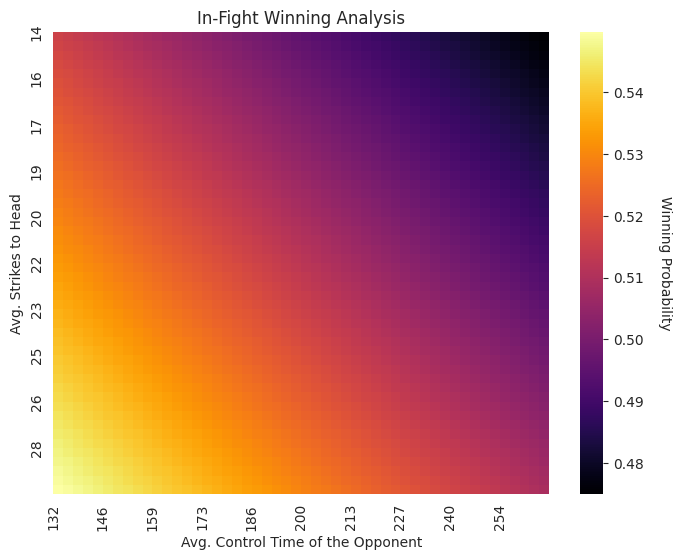

In [44]:
def in_fight_analysis(results):
    """
    This function conducts an in-fight analysis using the logistic regression model and test data from function regression_models_UFC. 
    
    The function generates a heatmap to visualize winning probabilities based on different 
    combinations of Average hits to the head landed and Average opponent's control time.

    Inputs:
    results (tuple): A tuple containing the fitted models, the predictions from each model, and the train-test split data. 
    This is the output from the 'regression_models_UFC' function.

    Outputs:
    None. The function plots a heatmap and does not return any values.
    """
    # Extract the logistic regression model and test data
    logit_reg = results[0][1]
    x_test = results[2][1]
    
    #Add constant term necessary to run logistic regression 
    x_test_copy = x_test.copy()
    x_test_copy = sm.add_constant(x_test_copy)

    # Select a rnadom fighter: fighter with index 69
    fighter = x_test_copy.iloc[69]

    # Get the existing values for Avg_HEAD_landed and Avg_opp_CTRL_time
    head_landed = fighter['Avg_HEAD_landed']
    opp_ctrl_time = fighter['Avg_opp_CTRL_time']

    # Create a grid of values for Avg_HEAD_landed and Avg_opp_CTRL_time, from their current values up to two times higher
    head_landed_grid = np.linspace(head_landed, 2 * head_landed, num=50)
    opp_ctrl_time_grid = np.linspace(opp_ctrl_time, 2 * opp_ctrl_time, num=50)

    # Initialize an empty array to store winning probabilities
    win_probs = np.zeros((50, 50))

    # Calculate winning probabilities for each combination of Avg_HEAD_landed and Avg_opp_CTRL_time values
    for i, h_l in enumerate(head_landed_grid):
        for j, o_c_t in enumerate(opp_ctrl_time_grid):
            fighter_modified = fighter.copy()
            fighter_modified['Avg_HEAD_landed'] = h_l
            fighter_modified['Avg_opp_CTRL_time'] = o_c_t

            prob = logit_reg.predict(fighter_modified)[0]
            win_probs[i, j] = prob

    # Create visualisation
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(win_probs, cmap='inferno', ax=ax)

    ax.set_xticks(np.arange(0, len(opp_ctrl_time_grid), 5))
    ax.set_yticks(np.arange(0, len(head_landed_grid), 5))
    ax.set_xticklabels(np.round(opp_ctrl_time_grid[::5]).astype(int), rotation=90)  # Rotate the x-axis labels
    ax.set_yticklabels(np.round(head_landed_grid[::5]).astype(int))
    # Add a title to the color bar
    cbar = ax.collections[0].colorbar
    cbar.set_label('Winning Probability', rotation=270, labelpad=20) #Rotate colour bar Rotate label

    plt.xlabel('Avg. Control Time of the Opponent')
    plt.ylabel('Avg. Strikes to Head')
    plt.title('In-Fight Winning Analysis')
    plt.show()

probablity_of_win = in_fight_analysis(results)


### P2.4.2 - Height-Reach Analysis (5 Marks)
Write a function `height_reach_analysis(df, results)` in order to analyse the effects of height and reach differences between fighters. You are asked to:

- take the dataframe `df` and regression modelling output object `results`.
- calculate height and reach differences for each specific fight.
  - A unique `'Match_ID'` corresponds to two different rows in `df`, e.g. the winner and the loser. 
  - For each pair you need to find the difference between columns and create two new columns with these values: `'dHeight'` and `'dReach'`. 
  - If fighter's values are higher, the specific difference value will be positive, otherwise you should set it to negative values. 
  - An example:
  ```
  	    Fighter	        Winner	   Height_cms	Reach_cms	   dHeight	 dReach   Match_ID
3132	Ray Borg	         1	      162.56	   160.02	     -2.54	   -10.16   975
8947	Jussier Formiga	  0	      165.10	   170.18	      2.54	    10.16   975
  ```
- filter out `df` for the test data and add a new column `'WinProb'` from the input argument `result` belonging to Probit regression.
- plot a scatter plot where `'dHeight'` and `'dReach'` correspond to axes and `'WinProb'` colour details of the plot. You must use `plotly.express` module for this question.

![](https://drive.google.com/uc?export=view&id=1rZFDAqaoIUP_2XAtCisrhgkKyRF7OGSP)

In [45]:
def height_reach_analysis(df, results):
  """
  Analyzes the influence of height and reach difference on the probability of winning a UFC fight.
    
  The function first calculates the height and reach difference between the two fighters for each match in the dataset.
  Then, it calculates the winning probability for the test data using the Probit regression model.
  Finally, it creates a scatter plot where each point represents a fight, with the x-coordinate being the height difference,
  the y-coordinate being the reach difference, and the color indicating the winning probability.

  Inputs:
    
  df (pd.DataFrame):
      The dataframe containing UFC fight data. Each row of the dataframe should correspond to a unique fighter-match pair.
      The dataframe should include the following columns: 'Match_ID', 'Fighter', 'Height_cms', 'Reach_cms', 'Winner'.
    
  results (tuple):
      The results tuple outputted by the 'regression_models_UFC' function. It includes trained regression models and
      training/testing data. The Probit regression model, which is the fourth element of the first item in the tuple,
      is used to calculate the winning probabilities.

  Outputs
    
  None. The function does not return any value. It creates and displays a scatter plot.
  """

  matches = df['Match_ID'].unique() #creates a list of all matches

  df1 = df.copy()

  dHeight_list = [None] * len(df1)
  dReach_list = [None] * len(df1)

  for match_id in matches:
      #identifies each match 
      match_rows = df1[df1['Match_ID'] == match_id].sort_values(by='Fighter')  
      
      # If a unique match has information just about one fighter, skip it
      if len(match_rows) != 2:
          continue

      # Find the two fighters
      fighter1 = match_rows.iloc[0]
      fighter2 = match_rows.iloc[1]

      # Calculate the differences and assign it
      dHeight = fighter1['Height_cms'] - fighter2['Height_cms']
      dReach = fighter1['Reach_cms'] - fighter2['Reach_cms']

      # Assign positive difference to the fighter with higher height or reach
      dHeight_list[fighter1.name] = np.sign(dHeight) * abs(dHeight)
      dHeight_list[fighter2.name] = np.sign(-dHeight) * abs(dHeight)
      dReach_list[fighter1.name] = np.sign(dReach) * abs(dReach)
      dReach_list[fighter2.name] = np.sign(-dReach) * abs(dReach)

      # Assign zero if difference is zero to prevent minus zeros
      if dHeight == 0:
          dHeight_list[fighter1.name] = 0
          dHeight_list[fighter2.name] = 0

      if dReach == 0:
          dReach_list[fighter1.name] = 0
          dReach_list[fighter2.name] = 0

  # Assign dHeight and dReach columns to the new DataFrame
  df1['dHeight'] = dHeight_list
  df1['dReach'] = dReach_list

  # Filter out df for the test data and add a new column 'WinProb' from the Probit regression
  probit_reg = results[0][3]
  x_test = results[2][1]
  test_ids = x_test.index
  test_df = df1.loc[df1.index.isin(test_ids)].copy()
  test_df.loc[:, 'WinProb'] = probit_reg.predict(sm.add_constant(x_test))

  # Plot a scatter plot with 'dHeight', 'dReach', and 'WinProb' as color
  fig = px.scatter(test_df, x='dHeight', y='dReach', 
                  color='WinProb', 
                  title='Height-Reach Analysis',
                  labels={'dHeight': 'Height Difference', 'dReach': 'Reach Difference'},
                  hover_data=["Fighter", "Winner", "Match_ID"])

  fig.update_traces(
      marker=dict(size=10),
      hovertemplate=(                    
          "Fighter: %{customdata[0]}<br>"
          "Winner: %{customdata[1]}<br>"
          "Match ID: %{customdata[2]}<br>"
          "Height Difference: %{x}<br>"
          "Reach Difference: %{y}<br>"
          "Winning Probability: %{marker.color:.2f}<extra></extra>"
      )
  )

  fig.update_coloraxes(colorbar_title="Winning Probability [Probit]")
  fig.update_layout(width=800, height=600)
  fig.show()

height_reach_analysis(df, results)

### 2.4.3 - Prediction Perfomance (6 marks)
You will now need to visualise the prediction performance of the models, and evaluate them in terms of prediction accuracy (Acc%), mean square error (MSE) and area under curve (AUC) metrics. For this purpose, create a function `prediction_perf(gt, MLE_model_predictions)` which evaluates the prediction performance of the reference models. Up to this point, you should have obtained

 - predictions from each model, stored in `model_predictions`.
 - The ground-truth values from data frames `df`, stored in `gt`.

Assume predicted values for a given model are stored in a variable $P$. The first performance measure will be the MSE, and will be calculated for each model from the expression below:

$$ MSE = \dfrac{1}{N}\sum_{i=0}^{N-1} (P_i - Winner_i)^2$$

In order to obtain the prediction accuracy for each model, you need to use `sklearn` module and its `accuracy_score()` function. Similarly, by using `sklearn` module methods `roc_curve()` and `auc()` find ROC curve parameters and AUC metric for each prediction model. 

In order to obtain performance analysis results in a neatly way, you then need to create a new `pandas` dataframe `df_results` which will be in the form of

```
+----+-------------+--------+--------+-------+
|    | Model       |   Acc% |    MSE |   AUC |
+====+=============+========+========+=======+
|  0 | Linear      |  77.00 | 0.1260 | 0.911 |
+----+-------------+--------+--------+-------+
|  1 | Logistic    |  81.00 | 0.1086 | 0.911 |
+----+-------------+--------+--------+-------+
|  2 | Probit      |  76.00 | 0.1490 | 0.884 |
+----+-------------+--------+--------+-------+
|  3 | Bayesian    |  76.00 | 0.1490 | 0.884 |
+----+-------------+--------+--------+-------+
```

Consequently, the `prediction_perf()` function should `print` and `return` the data frame `df_results`.

In [46]:
def prediction_perf(gt, model_predictions):
    """
    Evaluates the performance of several regression models based on their predictions.

    This function calculates the accuracy, Mean Squared Error (MSE), and Area Under the 
    Receiver Operating Characteristic Curve (AUC) for each model. The results are 
    then printed and returned as a pandas DataFrame.

    Inputs:
    gt(array-like):
        The ground truth values for the target variable.
    model_predictions(list of array-like):
        A list containing the predictions from each model. The predictions must 
        be in the same order as the model names specified in 'model_names'.

    Outputs:
        df_results(pandas DataFrame): A DataFrame containing the accuracy, MSE, and AUC for each model.
    """

    # Initialize lists to store evaluation metrics
    model_names = ['Linear', 'Logistic', 'Poisson', 'Bayesian']
    acc_values, mse_values, auc_values = [], [], []

    # Calculate metrics for each model's predictions
    for i, model_pred in enumerate(model_predictions):
        acc = accuracy_score(gt, np.round(model_pred)) * 100
        acc_values.append(acc)

        mse = sum((gt - model_pred) ** 2) / len(gt)
        mse_values.append(mse)

        fpr, tpr, _ = roc_curve(gt, model_pred)
        auc_score = auc(fpr, tpr)
        auc_values.append(auc_score)

    # Aggregate metrics into a DataFrame
    df_results = pd.DataFrame({'Model': model_names, 'Acc%': acc_values, 'MSE': mse_values, 'AUC': auc_values})
    
    print(df_results)
    return df_results

df_results = prediction_perf(results[2][3], results[1])


      Model       Acc%       MSE       AUC
0    Linear  56.577035  0.243201  0.589534
1  Logistic  56.540698  0.243224  0.589528
2   Poisson  56.140988  0.243456  0.588455
3  Bayesian  56.540698  0.243224  0.589528
